In [1]:
%env JOBLIB_TEMP_FOLDER=/data4/tangsp/tmp
%config InlineBackend.figure_formats = ['svg']
%load_ext autoreload
%autoreload 2

env: JOBLIB_TEMP_FOLDER=/data4/tangsp/tmp


In [2]:
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['FreeSans']

In [3]:
run = 9
run_idx_length = 10_000

In [4]:
input_dir = '../datagen/unif-100k/'
output_dir = './output/run{}/unif-10k/'.format(run)

In [5]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from collections import defaultdict
import pickle
import itertools
import copy
import random
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from sklearn import metrics

import joblib
from joblib import Parallel, delayed

# from OPE_utils import *

In [6]:
PROB_DIAB = 0.2
NSTEPS = 20     # max episode length

In [7]:
nS, nA = 1442, 8
d = 21

In [8]:
# Ground truth MDP model
MDP_parameters = joblib.load('../data/MDP_parameters.joblib')
P = MDP_parameters['transition_matrix_absorbing'] # (A, S, S_next)
R = MDP_parameters['reward_matrix_absorbing_SA'] # (S, A)
nS, nA = R.shape
gamma = 0.99

# unif rand isd, mixture of diabetic state
isd = joblib.load('../data/modified_prior_initial_state_absorbing.joblib')
isd = (isd > 0).astype(float)
isd[:720] = isd[:720] / isd[:720].sum() * (1-PROB_DIAB)
isd[720:] = isd[720:] / isd[720:].sum() * (PROB_DIAB)

In [9]:
# Optimal value function and optimal return
V_star = joblib.load('../data/V_π_star_PE.joblib')
J_star = V_star @ isd

In [10]:
def load_data(fname):
    print('Loading data', fname, '...', end='')
    df_data = pd.read_csv('{}/{}'.format(input_dir, fname)).rename(columns={'State_idx': 'State'})[['pt_id', 'Time', 'State', 'Action', 'Reward']]

    # Assign next state
    df_data['NextState'] = [*df_data['State'].iloc[1:].values, -1]
    df_data.loc[(df_data['Time'] == 19), 'NextState'] = -1
    df_data.loc[(df_data['Reward'] == -1), 'NextState'] = 1440
    df_data.loc[(df_data['Reward'] == 1), 'NextState'] = 1441

    assert ((df_data['Reward'] != 0) == (df_data['Action'] == -1)).all()

    print('DONE')
    return df_data

In [11]:
def load_sparse_features(fname):
    feat_dict = joblib.load('{}/{}'.format(input_dir, fname))
    INDS_init, X, A, X_next, R = feat_dict['inds_init'], feat_dict['X'], feat_dict['A'], feat_dict['X_next'], feat_dict['R']
    return INDS_init, X.toarray(), A, X_next.toarray(), R

### Use separate validation data

In [12]:
# Remember to modify both file paths!
va_split_name = 'va'
N = N_val = 10_000

df_va = load_data('2-features.csv').set_index('pt_id').loc[(200_000+run*run_idx_length):(200_000+run*run_idx_length+N-1)].reset_index()

vaINDS_init, vaX, vaA, vaX_next, vaR = load_sparse_features('2-21d-feature-matrices.sparse.joblib')
first_ind = vaINDS_init[run*run_idx_length]
last_ind = vaINDS_init[run*run_idx_length+N]
X, A, X_next, R_ = vaX[first_ind:last_ind], vaA[first_ind:last_ind], vaX_next[first_ind:last_ind], vaR[first_ind:last_ind]

INDS_init = vaINDS_init[run*run_idx_length:run*run_idx_length+N]
X_init = vaX[INDS_init]
INDS_init -= INDS_init[0]

Loading data 2-features.csv ...DONE


In [13]:
X.shape, A.shape, X_next.shape, R_.shape

((146966, 21), (146966,), (146966, 21), (146966,))

In [14]:
X_delta = X_next - X

In [15]:
import tensorflow as tf
from tensorflow import keras
from tf_utils import select_output_d, select_output

In [16]:
from OPE_utils_keras import *

## FQI

In [17]:
num_epoch = 50
Q_nets = [keras.models.load_model('{}/NFQ-clipped-keras.models/iter={}.Q_net'.format(output_dir, k), compile=False, custom_objects={'select_output': select_output}) for k in range(num_epoch+1)]
hidden_nets = [keras.models.load_model('{}/NFQ-clipped-keras.models/iter={}.hidden_net'.format(output_dir, k), compile=False) for k in range(num_epoch+1)]

## Ground-truth performance

In [18]:
# Make features for state-action pairs
X_ALL_states = []
for arrays in itertools.product(
    [[1,0], [0,1]], # Diabetic
    [[1,0,0], [0,1,0], [0,0,1]], # Heart Rate
    [[1,0,0], [0,1,0], [0,0,1]], # SysBP
    [[1,0], [0,1]], # Percent O2
    [[1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1]], # Glucose
    [[1,0], [0,1]], # Treat: AbX
    [[1,0], [0,1]], # Treat: Vaso
    [[1,0], [0,1]], # Treat: Vent
):
    X_ALL_states.append(np.concatenate(arrays))

X_ALL_states = np.array(X_ALL_states)
X_ALL_states.shape

(1440, 21)

In [19]:
Qs = [hidden_net.predict(X_ALL_states) for hidden_net in hidden_nets]
π_list = [convert_to_policy_table(Q) for Q in Qs]

In [20]:
FQI_value_list = [hidden_net.predict(X_init).max(axis=1).mean() for hidden_net in hidden_nets]

In [21]:
true_value_list = [isd @ policy_eval_analytic(P.transpose((1,0,2)), R, π, gamma) for π in π_list]

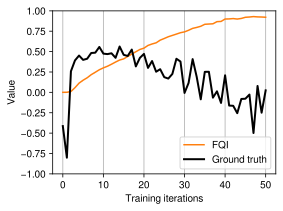

In [22]:
fig, axes = plt.subplots(figsize=(4,3))
plt.plot(FQI_value_list, color='tab:orange', label='FQI')
plt.plot(true_value_list,  color='k', lw=2, label='Ground truth')

plt.grid(axis='x')
plt.xlabel('Training iterations')
plt.ylabel('Value')
plt.legend()
plt.ylim(-1,1)
plt.show()

## WIS (epsilon)

In [23]:
eps_list = [0, 0.01, 0.05, 0.10, 0.50, 1]

In [24]:
features_tensor = format_features_tensor(df_va, X, INDS_init)

10000it [00:10, 929.35it/s]


In [25]:
WIS_value_lists = []
for eps in eps_list:
    WIS_value_list, WIS_N_list, WIS_ESS_list = zip(*Parallel(n_jobs=18)(delayed(OPE_WIS_keras)(features_tensor, k, gamma, output_dir, epsilon=eps, split=va_split_name) for k in tqdm(range(num_epoch+1))))
    WIS_value_lists.append(WIS_value_list)

100%|██████████| 51/51 [00:10<00:00,  4.94it/s]


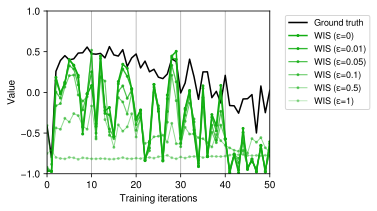

In [26]:
## Plot
fig, axes = plt.subplots(figsize=(4,3))
plt.plot(true_value_list,  color='k', lw=1.5, label='Ground truth')
for i, eps in enumerate(eps_list):
    plt.plot(WIS_value_lists[i], marker='.', markersize=4, color='#12AD12', lw=1.5-(i)/len(eps_list)*0.8, alpha=1-(i)*0.8/len(eps_list), label='WIS (ε={})'.format(eps))
plt.grid(axis='x')
plt.xlabel('Training iterations')
plt.ylabel('Value')
plt.xlim(0,50)
plt.ylim(-1,1)
plt.yticks(np.arange(-1, 1.1, 0.5))
plt.savefig('./fig/run{}/sepsis-cont-4-WIS_eps.pdf'.format(run), bbox_inches='tight')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), prop={'size': 9})
plt.show()

In [27]:
results = []
for eps, value_list in zip(eps_list, WIS_value_lists):
    if np.isnan(value_list).any():
        results.append([None, None, None, None])
        continue
    rho, pval = scipy.stats.spearmanr(true_value_list, value_list)
    mse = metrics.mean_squared_error(true_value_list, value_list)
    perf = true_value_list[np.argmax(value_list)]
    results.append([mse, rho, perf, np.max(true_value_list) - perf, J_star - perf])

df_results = pd.DataFrame(
    results, columns=['MSE', "Spearman", 'Performance', 'Regret', 'Suboptimality'], 
    index=['WIS (ε={})'.format(eps) for eps in eps_list]
).T
df_results.to_csv('./results/run{}/sepsis-cont-4-WIS_eps.csv'.format(run))
df_results

,WIS (ε=0),WIS (ε=0.01),WIS (ε=0.05),WIS (ε=0.1),WIS (ε=0.5),WIS (ε=1)
MSE,0.355263,0.356941,0.379348,0.417655,0.548061,1.066889
Spearman,0.671584,0.687783,0.733756,0.751674,0.643529,-0.864253
Performance,0.378269,0.412067,0.475075,0.475075,0.479317,-0.801185
Regret,0.184140,0.150343,0.087334,0.087334,0.083092,1.363595
Suboptimality,0.299273,0.265475,0.202467,0.202467,0.198224,1.478727


## AM (L)

In [28]:
L_list = [1, 5, 10, 20, 50]

In [29]:
AM_value_lists = []
for L in L_list:
    _, AM_value_list = zip(*Parallel(n_jobs=18)(delayed(OPE_AM_keras)(k, X_init, gamma, output_dir, rollout=L, split=va_split_name) for k in tqdm(range(num_epoch+1))))
    AM_value_lists.append(AM_value_list)

100%|██████████| 51/51 [01:07<00:00,  1.33s/it]


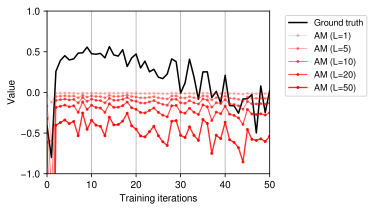

In [30]:
## Plot
fig, axes = plt.subplots(figsize=(4,3))
plt.plot(true_value_list,  color='k', lw=1.5, label='Ground truth')
for i, L in enumerate(L_list):
    plt.plot(AM_value_lists[i], marker='.', markersize=4, color='red', lw=1.5-(5-i)/len(L_list)*0.8, alpha=1-(5-i)*0.8/len(L_list), label='AM (L={})'.format(L))
plt.grid(axis='x')
plt.xlabel('Training iterations')
plt.ylabel('Value')
plt.xlim(0,50)
plt.ylim(-1,1)
plt.yticks(np.arange(-1, 1.1, 0.5))
plt.savefig('./fig/run{}/sepsis-cont-4-AM_L.pdf'.format(run), bbox_inches='tight')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), prop={'size': 9})
plt.show()

In [31]:
results = []
for L, value_list in zip(L_list, AM_value_lists):
    if np.isnan(value_list).any():
        results.append([None, None, None, None])
        continue
    rho, pval = scipy.stats.spearmanr(true_value_list, value_list)
    mse = metrics.mean_squared_error(true_value_list, value_list)
    perf = true_value_list[np.argmax(value_list)]
    results.append([mse, rho, perf, np.max(true_value_list) - perf, J_star - perf])

df_results = pd.DataFrame(
    results, columns=['MSE', "Spearman's $\rho$", 'Performance', 'Regret', 'Suboptimality'], 
    index=['AM (L={})'.format(L) for L in L_list]
).T
df_results.to_csv('./results/run{}/sepsis-cont-4-AM_L.csv'.format(run))
df_results

,AM (L=1),AM (L=5),AM (L=10),AM (L=20),AM (L=50)
MSE,0.125283,0.134727,0.164594,0.273602,0.838796
Spearman's $\rho$,0.743891,0.743891,0.743891,0.743891,0.743891
Performance,0.486603,0.486603,0.486603,0.486603,0.486603
Regret,0.075806,0.075806,0.075806,0.075806,0.075806
Suboptimality,0.190939,0.190939,0.190939,0.190939,0.190939


## FQE (L)

In [32]:
def get_FQE_value_keras_iterations(k, X, it, output_dir, split):
    try:
        model_FQE = keras.models.load_model('{}/NFQ-clipped-keras.{}FQE_models/iters/model={}_iter={}.hidden_net'.format(output_dir, split, k, it), custom_objects={'select_output': select_output}, compile=False)
        return model_FQE.predict(X).max(axis=1)
    except:
        return []

In [33]:
L_list = [1, 5, 10, 20, 50]

In [34]:
FQE_value_lists = []
for L in L_list:
    V_X_init = Parallel(n_jobs=18)(delayed(get_FQE_value_keras_iterations)(k, X_init, L, output_dir, split=va_split_name) for k in tqdm(range(num_epoch+1)))
    FQE_value_list = [np.nanmean(V_init) for V_init in V_X_init]
    FQE_value_lists.append(FQE_value_list)

100%|██████████| 51/51 [00:00<00:00, 71.62it/s]


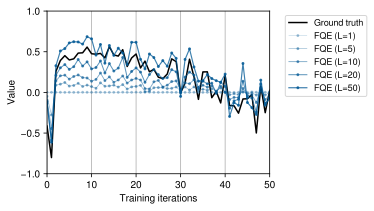

In [35]:
## Plot
fig, axes = plt.subplots(figsize=(4,3))
plt.plot(true_value_list,  color='k', lw=1.5, label='Ground truth')
for i, L in enumerate(L_list):
    plt.plot(FQE_value_lists[i], marker='.', markersize=4, color='#005895', lw=1.5-(6-i)/len(L_list)*0.8, alpha=1-(6-i)*0.6/len(L_list), label='FQE (L={})'.format(L))
plt.grid(axis='x')
plt.xlabel('Training iterations')
plt.ylabel('Value')
plt.xlim(0,50)
plt.ylim(-1,1)
plt.yticks(np.arange(-1, 1.1, 0.5))
plt.savefig('./fig/run{}/sepsis-cont-4-FQE_L.pdf'.format(run), bbox_inches='tight')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), prop={'size': 9})
plt.show()

In [36]:
results = []
for L, value_list in zip(L_list, FQE_value_lists):
    if np.isnan(value_list).any():
        results.append([None, None, None, None])
        continue
    rho, pval = scipy.stats.spearmanr(true_value_list, value_list)
    mse = metrics.mean_squared_error(true_value_list, value_list)
    perf = true_value_list[np.argmax(value_list)]
    results.append([mse, rho, perf, np.max(true_value_list) - perf, J_star - perf])

df_results = pd.DataFrame(
    results, columns=['MSE', "Spearman's $\rho$", 'Performance', 'Regret', 'Suboptimality'], 
    index=['FQE (L={})'.format(L) for L in L_list]
).T
df_results.to_csv('./results/run{}/sepsis-cont-4-FQE_L.csv'.format(run))
df_results

,FQE (L=1),FQE (L=5),FQE (L=10),FQE (L=20),FQE (L=50)
MSE,0.124762,0.084966,0.051540,0.019742,0.023817
Spearman's $\rho$,-0.084434,0.817919,0.870226,0.934027,0.902986
Performance,-0.026990,0.451421,0.479317,0.524817,0.556815
Regret,0.589400,0.110988,0.083092,0.037593,0.005595
Suboptimality,0.704532,0.226120,0.198224,0.152725,0.120727
